In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader
from dataset import CityscapesDataset
from tqdm import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"🟢 Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("🟡 Using CPU")

# Parametri
batch_size = 4
num_classes = 19
epochs = 15
resize = (256, 512)

# Trasformazioni
transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])

# Dataset e DataLoader
train_dataset = CityscapesDataset(root='datasets/cityscapes', split='train', transform=transform, resize=resize)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(),persistent_workers=True, pin_memory=True)

# Modello
model = deeplabv3_resnet50(weight=False, num_classes=num_classes).to(device)

start_epoch = 0
checkpoint_path = 'deeplabv3_cityscapes.pth'
if os.path.exists(checkpoint_path):
    print("🔁 Checkpoint trovato: ripristino stato del modello...")
    checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
    model.load_state_dict(checkpoint['model'])
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
else:
    optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Loss e ottimizzatore
criterion = nn.CrossEntropyLoss(ignore_index=255)

# Training loop
scaler = torch.amp.GradScaler('cuda')
for epoch in range(start_epoch, start_epoch + epochs):
    
    start = time.time()
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{start_epoch + epochs}")
    for images, masks in loop:
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        #print("UNIQUE LABELS IN BATCH:", torch.unique(masks))
        with torch.amp.autocast('cuda'):
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() 

    elapsed = time.time() - start
    print(f"✅ Epoch {epoch+1}/{start_epoch+epochs} - Avg Loss: {running_loss/len(train_loader):.4f} - Time: {elapsed:.2f} sec")

# Salva il modello
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch
}, checkpoint_path)

🟢 Using GPU: NVIDIA GeForce RTX 4070
🔁 Checkpoint trovato: ripristino stato del modello...


Epoch 33/47: 100%|██████████| 744/744 [01:15<00:00,  9.90it/s]


✅ Epoch 33/47 - Avg Loss: 0.0010 - Time: 75.12 sec


Epoch 34/47: 100%|██████████| 744/744 [01:07<00:00, 11.08it/s]


✅ Epoch 34/47 - Avg Loss: 0.0007 - Time: 67.14 sec


Epoch 35/47: 100%|██████████| 744/744 [01:06<00:00, 11.15it/s]


✅ Epoch 35/47 - Avg Loss: 0.0019 - Time: 66.76 sec


Epoch 36/47: 100%|██████████| 744/744 [01:08<00:00, 10.82it/s]


✅ Epoch 36/47 - Avg Loss: 0.0006 - Time: 68.75 sec


Epoch 37/47: 100%|██████████| 744/744 [01:08<00:00, 10.84it/s]


✅ Epoch 37/47 - Avg Loss: 0.0004 - Time: 68.61 sec


Epoch 38/47: 100%|██████████| 744/744 [01:11<00:00, 10.46it/s]


✅ Epoch 38/47 - Avg Loss: 0.0003 - Time: 71.13 sec


Epoch 39/47: 100%|██████████| 744/744 [01:14<00:00, 10.01it/s]


✅ Epoch 39/47 - Avg Loss: 0.0023 - Time: 74.32 sec


Epoch 40/47: 100%|██████████| 744/744 [01:12<00:00, 10.23it/s]


✅ Epoch 40/47 - Avg Loss: 0.0013 - Time: 72.70 sec


Epoch 41/47: 100%|██████████| 744/744 [01:14<00:00, 10.03it/s]


✅ Epoch 41/47 - Avg Loss: 0.0005 - Time: 74.15 sec


Epoch 42/47: 100%|██████████| 744/744 [01:17<00:00,  9.66it/s]


✅ Epoch 42/47 - Avg Loss: 0.0003 - Time: 77.02 sec


Epoch 43/47: 100%|██████████| 744/744 [01:18<00:00,  9.53it/s]


✅ Epoch 43/47 - Avg Loss: 0.0008 - Time: 78.07 sec


Epoch 44/47: 100%|██████████| 744/744 [01:16<00:00,  9.74it/s]


✅ Epoch 44/47 - Avg Loss: 0.0009 - Time: 76.40 sec


Epoch 45/47: 100%|██████████| 744/744 [01:17<00:00,  9.63it/s]


✅ Epoch 45/47 - Avg Loss: 0.0003 - Time: 77.26 sec


Epoch 46/47: 100%|██████████| 744/744 [01:15<00:00,  9.81it/s]


✅ Epoch 46/47 - Avg Loss: 0.0004 - Time: 75.84 sec


Epoch 47/47: 100%|██████████| 744/744 [01:13<00:00, 10.17it/s]


✅ Epoch 47/47 - Avg Loss: 0.0003 - Time: 73.16 sec


🟢 Using GPU: NVIDIA GeForce RTX 4070


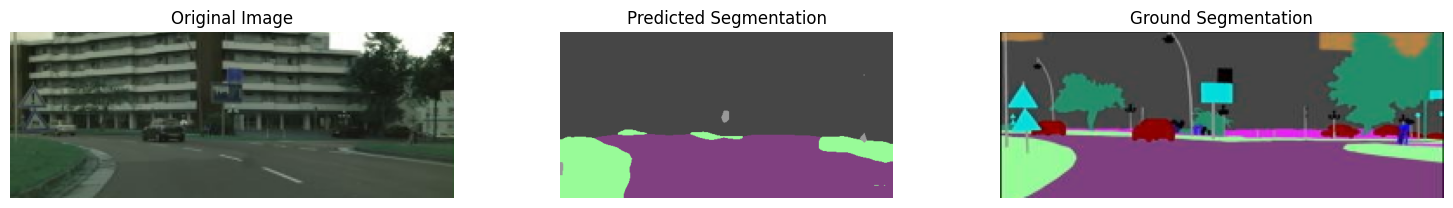

In [37]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from dataset import COLORS

# 🔧 Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"🟢 Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("🟡 Using CPU")

num_classes = 19
model_path = 'deeplabv3_cityscapes.pth'
image_path = 'datasets/cityscapes/train/img/train1.png'  
ground_image_path = 'datasets/cityscapes/train/label/train1.png' 
resize = (256, 512)  


def decode_segmap(pred):
    h, w = pred.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label in range(num_classes):
        color_mask[pred == label] = COLORS[label]
    return color_mask

# 📦 Load model
model = deeplabv3_resnet50(weight=False, num_classes=num_classes).to(device)
checkpoint = torch.load(model_path, map_location=device,weights_only=False)
model.load_state_dict(checkpoint['model'])

model.eval()

# 🖼️ Load and preprocess image
image = Image.open(image_path).convert('RGB')
ground_image = Image.open(ground_image_path) 
original_size = image.size

transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)

# 🔍 Inference
with torch.no_grad():
    output = model(input_tensor)['out']
    output = torch.nn.functional.interpolate(output, size=resize, mode='bilinear', align_corners=False)
    prediction = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
    seg_image = decode_segmap(prediction)

# 📊 Visualizzazione
plt.figure(figsize=(15, 4))
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Predicted Segmentation")
plt.imshow(seg_image)
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Ground Segmentation")
plt.imshow(ground_image)
plt.axis('off')

plt.tight_layout()
plt.show()
